In [1]:
# This is an implementation of the dynamic pricing model from
#
# Ferreira, Kris and Simchi-Levi, David and Wang, He, 
# Online Network Revenue Management Using Thompson Sampling (November 7, 2017). 
# Operations Research, Forthcoming. 
# Available at SSRN: https://ssrn.com/abstract=2588730 or http://dx.doi.org/10.2139/ssrn.2588730
# https://pdfs.semanticscholar.org/6dce/31c44fb1ad1b8dbe231f7654c37506daa909.pdf

# See also https://blog.griddynamics.com/dynamic-pricing-algorithms/

In [2]:
import numpy as np
from tabulate import tabulate
from scipy.optimize import linprog
import scipy.stats as stats 
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation

np.set_printoptions(precision=2)

def tabprint(msg, A):
    print(msg)
    print(tabulate(A, tablefmt="fancy_grid"))

In [3]:
# Find the optimal distribution of prices (price probabilities) given fixed price levels, 
# corresponding demand levels, and availbale product inventory.
# 
# Inputs:
#   prices, demands, and revenues are vectors (i-th element corresponds to i-th price level)
#   inventory is a scalar (number of availbale units)
def optimal_price_probabilities(prices, demands, inventory):   
    revenues = np.multiply(prices, demands)
    
    L = len(prices)
    M = np.full([1, L], 1)
    B = [[1]]
    Df = [demands]

    res = linprog(-np.array(revenues).flatten(), 
                  A_eq=M, 
                  b_eq=B, 
                  A_ub=Df, 
                  b_ub=np.array([inventory]), 
                  bounds=(0, None))

    price_prob = np.array(res.x).reshape(1, L).flatten()
    return price_prob

In [4]:
# Optimization procedure test
prices = [1.99, 2.49, 2.99, 3.49, 3.99, 4.49]
demands = list(map(lambda p: 50 - 7*p, prices))
revenues = np.multiply(prices, demands)
print(demands)
print(revenues)
print(optimal_price_probabilities(prices, demands, 60))

[36.07, 32.57, 29.07, 25.57, 22.07, 18.57]
[71.78 81.1  86.92 89.24 88.06 83.38]
[8.31e-13 1.66e-12 4.68e-12 1.00e+00 1.16e-11 2.14e-12]


In [5]:
prices = [1.99, 2.49, 2.99, 3.49, 3.99, 4.49]

# Hidden (true) demand parameters - a linear demans function is assumed
demand_a = 50
demand_b = 7

# prior distribution for each price - gamma(α, β)
θ = []
for p in prices:
    θ.append({'price': p, 'alpha': 30.00, 'beta': 1.00, 'mean': 30.00})

def gamma(alpha, beta):
    shape = alpha
    scale = 1/beta
    return np.random.gamma(shape, scale)

def sample_demand(price):
    demand = demand_a - demand_b * price
    return np.random.poisson(demand, 1)[0]

def sample_demands_from_model(θ):
    return list(map(lambda v: gamma(v['alpha'], v['beta']), θ))
        
T = 50
history = []
for t in range(0, T):              # simulation loop
    demands = sample_demands_from_model(θ)
    print(tabulate(np.array(θ), tablefmt="fancy_grid"))
    
    print("demands = ", np.array(demands))
    
    price_probs = optimal_price_probabilities(prices, demands, 60)
    
    # select one best price
    price_index_t = np.random.choice(len(prices), 1, p=price_probs)[0]
    price_t = prices[price_index_t]
    
    # sell at the selected price and observe demand
    demand_t = sample_demand(price_t)
    print('selected price %.2f => demand %.2f, revenue %.2f' % (price_t, demand_t, demand_t*price_t))
    
    theta_trace = []
    for v in θ:
        theta_trace.append(v.copy())
    history.append([price_t, demand_t, demand_t*price_t, theta_trace])
    
    # update model parameters
    v = θ[price_index_t]
    v['alpha'] = v['alpha'] + demand_t
    v['beta'] = v['beta'] + 1
    v['mean'] = v['alpha'] / v['beta']
    
    print("")
    

╒══════╤════╤═══╤════╕
│ 1.99 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 2.49 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 2.99 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 3.49 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 3.99 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 4.49 │ 30 │ 1 │ 30 │
╘══════╧════╧═══╧════╛
demands =  [26.82 29.99 34.73 45.55 26.02 36.67]
selected price 4.49 => demand 28.00, revenue 125.72

╒══════╤════╤═══╤════╕
│ 1.99 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 2.49 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 2.99 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 3.49 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 3.99 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 4.49 │ 58 │ 2 │ 29 │
╘══════╧════╧═══╧════╛
demands =  [32.12 25.87 25.41 36.5  28.62 27.01]
selected price 3.49 => demand 27.00, revenue 94.23

╒══════╤════╤═══╤══════╕
│ 1.99 │ 30 │ 1 │ 30   │
├──────┼────┼───┼──────┤
│ 2.49 │ 30 │ 1 │ 30   │
├──────┼────┼───┼──────┤
│ 2.99 │ 30 │ 1 │ 30   │
├──────┼────┼───┼──────┤
│ 3.49 │ 57 │ 2 │ 28.5 │

selected price 3.49 => demand 25.00, revenue 87.25

╒══════╤═════╤════╤═════════╕
│ 1.99 │  30 │  1 │ 30      │
├──────┼─────┼────┼─────────┤
│ 2.49 │  60 │  2 │ 30      │
├──────┼─────┼────┼─────────┤
│ 2.99 │ 146 │  5 │ 29.2    │
├──────┼─────┼────┼─────────┤
│ 3.49 │ 155 │  6 │ 25.8333 │
├──────┼─────┼────┼─────────┤
│ 3.99 │ 348 │ 15 │ 23.2    │
├──────┼─────┼────┼─────────┤
│ 4.49 │ 191 │ 10 │ 19.1    │
╘══════╧═════╧════╧═════════╛
demands =  [36.78 29.61 29.19 22.46 23.83 18.19]
selected price 3.99 => demand 27.00, revenue 107.73

╒══════╤═════╤════╤═════════╕
│ 1.99 │  30 │  1 │ 30      │
├──────┼─────┼────┼─────────┤
│ 2.49 │  60 │  2 │ 30      │
├──────┼─────┼────┼─────────┤
│ 2.99 │ 146 │  5 │ 29.2    │
├──────┼─────┼────┼─────────┤
│ 3.49 │ 155 │  6 │ 25.8333 │
├──────┼─────┼────┼─────────┤
│ 3.99 │ 375 │ 16 │ 23.4375 │
├──────┼─────┼────┼─────────┤
│ 4.49 │ 191 │ 10 │ 19.1    │
╘══════╧═════╧════╧═════════╛
demands =  [34.1  34.16 30.37 24.56 24.06 21.06]
selected price 3.

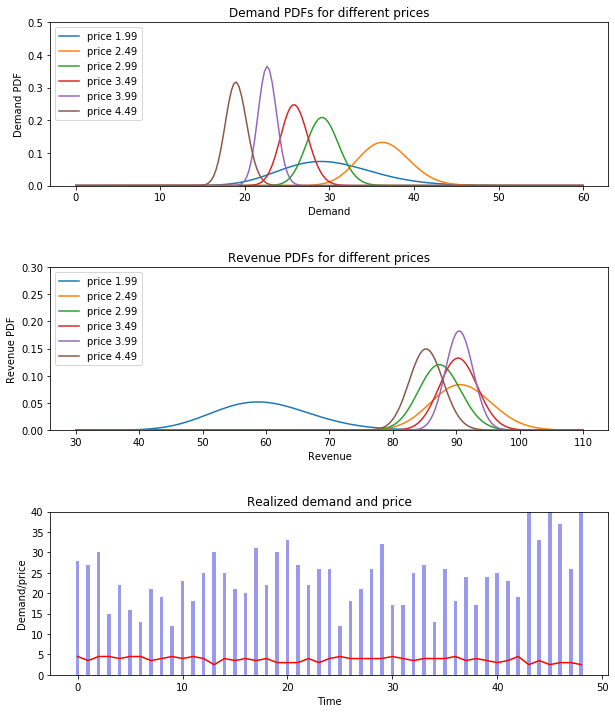

In [6]:
def visualize_snapshot(t):
    plt.subplot(3, 1, 1)
    plt.xlabel('Demand')
    plt.ylabel('Demand PDF')
    plt.title('Demand PDFs for different prices')
    x = np.linspace(0, 60, 200) 
    for i, params in enumerate(history[t][3]):
        y = stats.gamma.pdf(x, a=params['alpha'], scale=1.0/params['beta']) 
        plt.plot(x, y, "-", label='price %.2f' % params['price']) 
    plt.legend(loc='upper left')
    plt.ylim([0, 0.5])

    plt.subplot(3, 1, 2)
    plt.xlabel('Revenue')
    plt.ylabel('Revenue PDF')
    plt.title('Revenue PDFs for different prices')
    x = np.linspace(30, 110, 200) 
    for i, params in enumerate(history[t][3]):
        y = stats.gamma.pdf(x, a=params['alpha']*params['price'], scale=1.0/params['beta']) 
        plt.plot(x, y, "-", label='price %.2f' % params['price']) 
    plt.legend(loc='upper left')
    plt.ylim([0, 0.3])
    
    plt.subplot(3, 1, 3)
    plt.xlabel('Time')
    plt.ylabel('Demand/price')
    plt.title('Realized demand and price')
    plt.plot(range(0, t+1), np.array(history)[0:t+1, 0], 'r-') 
    plt.bar(range(0, T-1), np.pad(np.array(history)[0:t+1, 1], (0, T-2-t), 'constant'), 0.35, color='#9999ee')
    plt.ylim([0, 40])

fig = plt.figure(figsize = (10, 12))
plt.subplots_adjust(hspace = 0.5)
visualize_snapshot(T - 2)                 # fisualize the final state of the simulation
plt.show()

In [9]:
# https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available

In [10]:
# Render and save the animation of the simulation process

fig = plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)

t = 0
def animate(f):
    global t
    fig.clear()
    visualize_snapshot(t)
    t = t + 1
    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, bitrate=2800)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames = T-3, repeat = True)

ani.save('thompson_test_run.gif', writer='imagemagick', fps = 10, dpi = 90)

RuntimeError: Requested MovieWriter (ffmpeg) not available

<Figure size 720x864 with 0 Axes>